In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from dataGenerator import small_dset_gen

In [2]:
os.chdir("C:/Users/Greg/code/space physics/experiment/data")

mag_file = "mag_data_2004.nc"
ss_file = "substorms_2000_2018.csv"
stats_file = "statistics.npz"
data_interval = 128
prediction_interval = 64
channels = 3

BATCHSIZE = 32

gen = small_dset_gen(mag_file, ss_file, stats_file, data_interval, prediction_interval)


0 0.7344618 0.39285714285714285


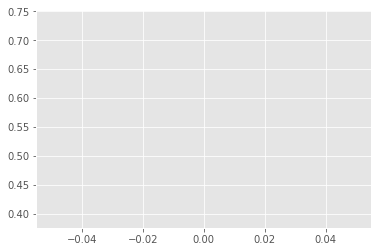

5 0.67168397 0.6071428571428571


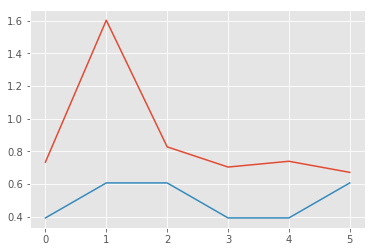

10 0.6604203 0.6785714285714286


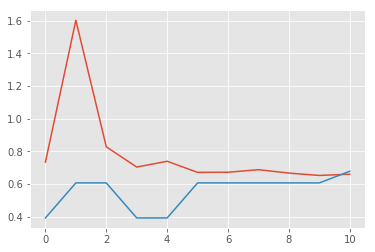

15 0.6388034 0.6071428571428571


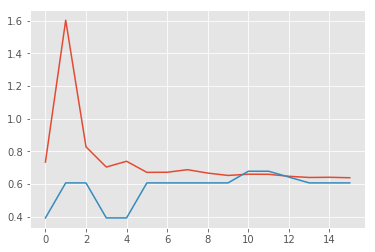

20 0.6033155 0.75


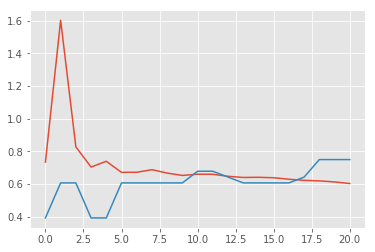

25 0.55799824 0.75


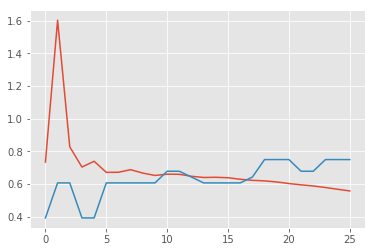

30 0.49101081 0.8571428571428571


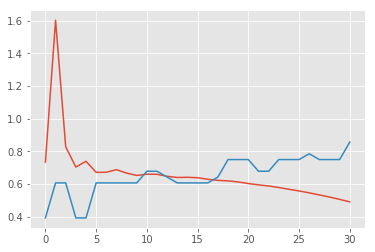

35 0.41115767 0.8571428571428571


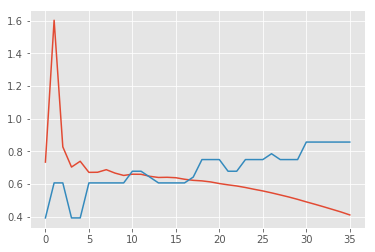

40 0.32221478 0.8928571428571429


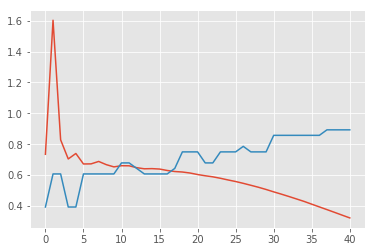

45 0.24072449 0.9642857142857143


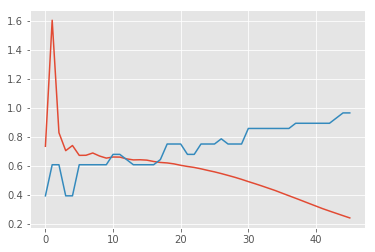

50 0.17445867 0.9642857142857143


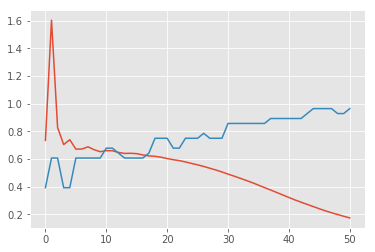

55 0.122950725 1.0


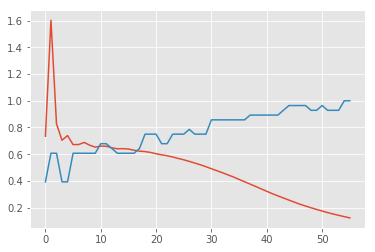

60 0.08458849 1.0


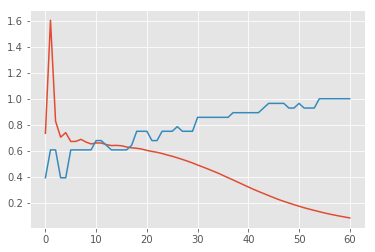

65 0.05780541 1.0


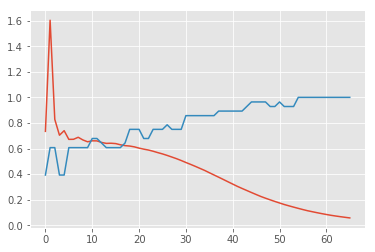

70 0.039918013 1.0


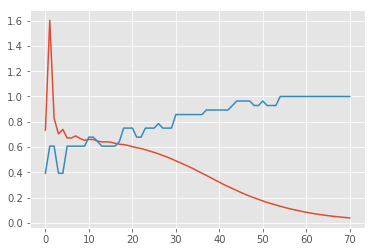

75 0.028404774 1.0


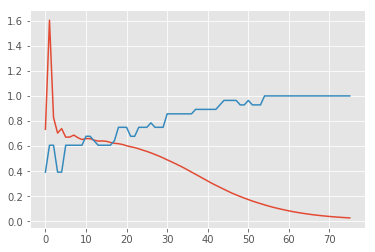

80 0.0211544 1.0


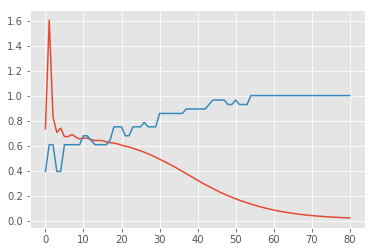

85 0.016452793 1.0


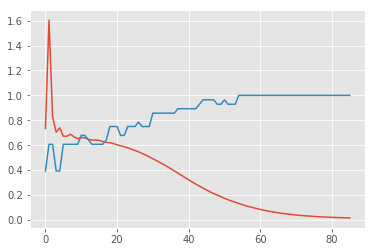

90 0.013367495 1.0


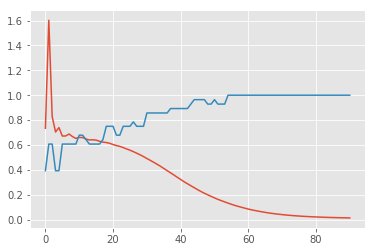

95 0.011255349 1.0


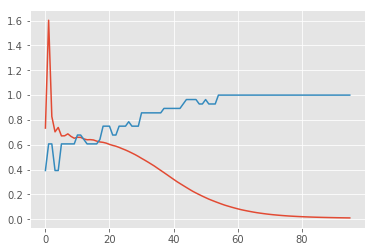

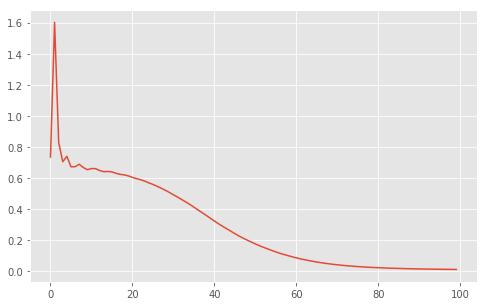

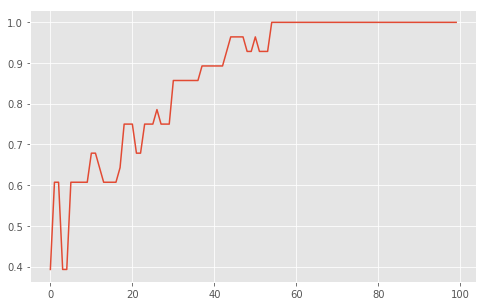

In [6]:
tf.reset_default_graph()

dataset = tf.data.Dataset.from_generator(gen,
                                         output_types = (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32),
                                         output_shapes = (tf.TensorShape([None, data_interval, channels]),
                                                          tf.TensorShape([None, 3]),
                                                          tf.TensorShape([1]),
                                                          tf.TensorShape([1]),
                                                          tf.TensorShape([3]))
                                        )

dataset = dataset.padded_batch(BATCHSIZE, (tf.TensorShape([None, data_interval, channels]),
                                           tf.TensorShape([None, 3]), 
                                           tf.TensorShape([1]), 
                                           tf.TensorShape([1]),
                                           tf.TensorShape([3]))).repeat()

data_iter = dataset.make_initializable_iterator()

mag, st_loc, occ, ss_t, ss_loc = data_iter.get_next()

learning_rate = tf.placeholder(tf.float32)
    
# conv - conv - pool
c1_kernel = tf.get_variable("c1_kernel", shape=(1, 3, channels, 16))
C1 = tf.nn.relu(tf.nn.conv2d(mag, c1_kernel, [1,1,1,1], padding="SAME"))
c2_kernel = tf.get_variable("c2_kernel", shape=(1, 3, 16, 16))
C2 = tf.nn.relu(tf.nn.conv2d(C1, c2_kernel, [1,1,1,1], padding="SAME"))
P1 = tf.nn.max_pool(C2, ksize=[1,1,2,1], strides=[1,1,2,1], padding="SAME")
# conv - conv - pool
c3_kernel = tf.get_variable("c3_kernel", shape=(1, 3, 16, 32))
C3 = tf.nn.relu(tf.nn.conv2d(P1, c3_kernel, [1,1,1,1], padding="SAME"))
c4_kernel = tf.get_variable("c4_kernel", shape=(1, 3, 32, 32))
C4 = tf.nn.relu(tf.nn.conv2d(C3, c4_kernel, [1,1,1,1], padding="SAME"))
P2 = tf.nn.max_pool(C2, ksize=[1,1,2,1], strides=[1,1,2,1], padding="SAME")
# batch x ? x N/8 x 64

# FC layers
sh = tf.shape(P2)
vectors = tf.reshape(P2, [sh[0], sh[1], 1024])
FC1 = tf.nn.relu(tf.layers.dense(vectors, 512))
FC2 = tf.nn.relu(tf.layers.dense(FC1, 512))

# sum - FC layers
inp_sum = tf.reduce_max(FC2, axis=1)
FC3 = tf.nn.relu(tf.layers.dense(inp_sum, 512))
model_output = tf.layers.dense(FC3, 1)

conf = tf.nn.sigmoid(model_output)
    
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=occ, logits=model_output))

opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = opt.minimize(loss)
grads = opt.compute_gradients(loss)

lr = .001

sess = tf.Session()
lh = []
acc = []

plt.figure()
sess.run(tf.global_variables_initializer())
sess.run(data_iter.initializer)
for i in range(100):
    v, t, l, o = sess.run([conf, occ, loss, model_output])
    a = np.mean(np.round(v)==t)
    lh.append(l)
    acc.append(a)
    sess.run(train_step, feed_dict={learning_rate: lr})
    if i % 5 == 0:
#         lr *= .9
        print(i, l, a)
        plt.plot(lh)
        plt.plot(acc)
        plt.show()

plt.figure(figsize=(8,5))    
plt.plot(lh)
plt.figure(figsize=(8,5))    
plt.plot(acc)

In [9]:
np.concatenate((v, np.round(v), t), axis=1)

array([[3.6249283e-05, 0.0000000e+00, 0.0000000e+00],
       [9.9617767e-01, 1.0000000e+00, 1.0000000e+00],
       [3.2149692e-04, 0.0000000e+00, 0.0000000e+00],
       [9.9643767e-01, 1.0000000e+00, 1.0000000e+00],
       [9.9481505e-01, 1.0000000e+00, 1.0000000e+00],
       [3.7959809e-03, 0.0000000e+00, 0.0000000e+00],
       [9.5573539e-01, 1.0000000e+00, 1.0000000e+00],
       [4.4090918e-04, 0.0000000e+00, 0.0000000e+00],
       [1.0938752e-02, 0.0000000e+00, 0.0000000e+00],
       [1.4436905e-03, 0.0000000e+00, 0.0000000e+00],
       [1.5767377e-02, 0.0000000e+00, 0.0000000e+00],
       [1.2341454e-07, 0.0000000e+00, 0.0000000e+00],
       [1.5737221e-02, 0.0000000e+00, 0.0000000e+00],
       [3.6187046e-03, 0.0000000e+00, 0.0000000e+00],
       [9.8269373e-01, 1.0000000e+00, 1.0000000e+00],
       [2.9836330e-03, 0.0000000e+00, 0.0000000e+00],
       [1.3856778e-03, 0.0000000e+00, 0.0000000e+00],
       [4.2620781e-03, 0.0000000e+00, 0.0000000e+00],
       [8.0959778e-03, 0.000